In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import torch
from torch import nn
import torch
import time
import unet

import swyft
import pylab as plt
import scipy.stats.distributions as dist

torch.set_float32_matmul_precision('medium')
DEVICE = "cuda"

/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Generative model

In [45]:
bounds = None

In [3]:
class SimulatorBlob(swyft.Simulator):
    def __init__(self, bounds = None, Npix = 64, sigma = 0.1):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.theta_sampler = swyft.RectBoundSampler([dist.uniform(4., 0.1)])
        self.bounds = bounds
        self.Npix = Npix
        self.sigma = sigma
        self.powersampler = swyft.utils.PowerSpectrumSampler(Npix)
        self.sigma = torch.ones(Npix, Npix)*0.1
#        self.sigma[:,:Npix//2] *= 1000

    def get_pk_fn(self, theta):
        return lambda k: 1e6*3*(k/0.5)**-theta[0]
        
    def sample_delta(self, pk_fn):
        if self.bounds is not None:
            i = np.random.randint(len(self.bounds))
            return torch.tensor(self.bounds[i])
        else:
#            return self.powersampler.sample(lambda k: 1e6*3*(k/0.5)**-theta[0])
            return self.powersampler.sample(pk_fn)
            
    def build(self, graph):
        theta = graph.node("theta", self.theta_sampler)
        pk_fn = graph.node("pk_fn", self.get_pk_fn, theta)
        delta = graph.node("delta", self.sample_delta, pk_fn)
        rho = graph.node("rho", lambda delta: torch.exp(delta/5), delta)
        x = graph.node("x", lambda rho: rho + torch.randn(self.Npix, self.Npix)*self.sigma, rho)
#        z = graph.node("test", lambda: lambda x: x)

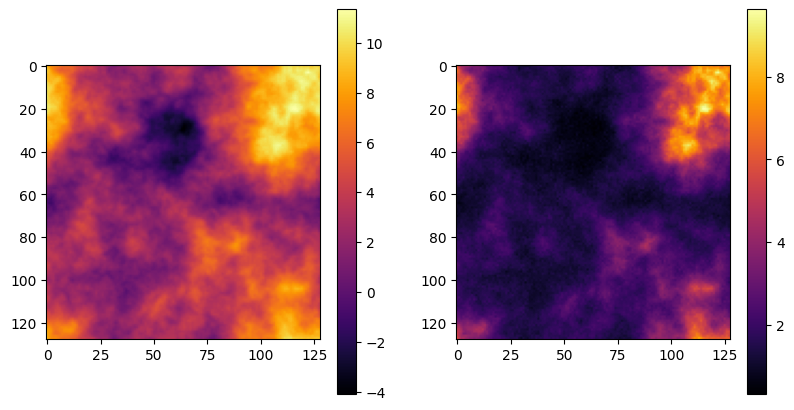

In [13]:
NPIX = 128
sim = SimulatorBlob(Npix = NPIX)
sample0 = sim.sample()
plt.figure(figsize = (15, 5))
plt.subplot(131)
plt.imshow(sample0['delta'], cmap = 'inferno')
plt.colorbar()
plt.subplot(132)
plt.imshow(sample0['x'], cmap = 'inferno')
plt.colorbar()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 784.75it/s]


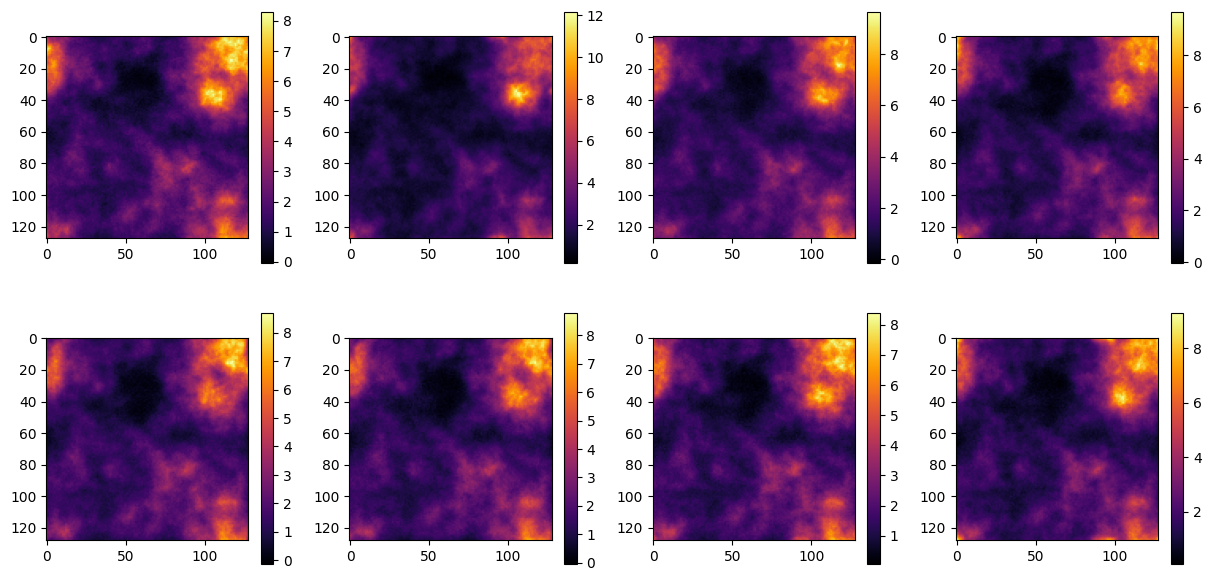

In [166]:
#NPIX = 128
sim = SimulatorBlob(Npix = NPIX, bounds = bounds)
samples = sim.sample(8)
plt.figure(figsize = (15, 15))
for i in range(8):
    plt.subplot(4, 4, i+1)
    plt.imshow(samples[i]['x'], cmap = 'inferno')
    plt.colorbar()

### Inference network

In [137]:
class Network(swyft.SwyftModule):
    def __init__(self, lr=1e-3, N = 1024):
        super().__init__()
        self.optimizer_init = swyft.AdamOptimizerInit(lr=1e-4, lrs_factor=0.1, lrs_patience=3)
        self.N = N
        L = lambda x: x*0
        self.Phi = lambda x: x
        self.PhiT = lambda x: x
        self.lre = swyft.LogRatioEstimator_Gaussian_Autoregressive_X_module_based(
            self.N**2, "mu", Phi = self.Phi, PhiT = self.PhiT, L = L, minstd = 1e-5, momentum=0.02)
        self.unet = unet.UNet(1, 1, s = 4)
    
    def embed(self, x):
        x = self.unet(x.unsqueeze(1)).squeeze(1) + x
        x = x.view(-1, self.N**2)
        return x

    def forward(self, A, B):
        N = self.N
        rhoA = self.embed(A['x'])
        rhoB = self.embed(B['x'])
        deltaB = B['delta'].view(-1, N**2)
        result = self.lre(rhoA, rhoB, deltaB)
        return result

### Inference

In [138]:
sim = SimulatorBlob(Npix = NPIX, bounds = bounds)
samples = sim.sample(1000, exclude = ['pk_fn'])
#net.cpu(); net.float()
dm = swyft.SwyftDataModule(samples, fractions = [0.9, 0.1, 0.0], batch_size = 64)
net = Network(N = NPIX)
trainer = swyft.SwyftTrainer(accelerator = "gpu", devices = 1, max_epochs = 40)
trainer.fit(net, dm)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1983.41it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                                                     | Params
----------------------------------------------------------------------------------
0 | lre  | LogRatioEstimator_Gaussian_Autoregressive_X_module_based | 0     
1 | unet | UNet                                                     | 1.9 M 
----------------------------------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.769     Total estimated model params size (MB)


Epoch 0:  88%|███████████████████████████████████████████████████████████████████▉         | 15/17 [00:01<00:00,  8.60it/s, loss=-9.53e+03, v_num=232]
Validation: 0it [00:00, ?it/s]
Epoch 1:  88%|███████████████████████████████████████████████████▏      | 15/17 [00:01<00:00,  8.68it/s, loss=-1.77e+04, v_num=232, val_loss=-1.91e+4]
Validation: 0it [00:00, ?it/s]
Epoch 2:  88%|███████████████████████████████████████████████████▏      | 15/17 [00:01<00:00,  8.64it/s, loss=-1.93e+04, v_num=232, val_loss=-1.95e+4]
Validation: 0it [00:00, ?it/s]
Epoch 3:  88%|███████████████████████████████████████████████████▏      | 15/17 [00:01<00:00,  8.57it/s, loss=-2.03e+04, v_num=232, val_loss=-2.02e+4]
Validation: 0it [00:00, ?it/s]
Epoch 4:  88%|███████████████████████████████████████████████████▏      | 15/17 [00:01<00:00,  8.53it/s, loss=-2.12e+04, v_num=232, val_loss=-2.09e+4]
Validation: 0it [00:00, ?it/s]
Epoch 5:  88%|███████████████████████████████████████████████████▏      | 15/17 [00:01<00:

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|█████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  8.63it/s, loss=-2.98e+04, v_num=232, val_loss=-2.96e+4]


### Evaluation

In [156]:
GAMMA = 0.1 # 0.1 # 0.0001

x = sample0['x']
y = net.cuda().double().embed(torch.tensor(x).cuda().double().unsqueeze(0))[0]
pk = SimulatorBlob(Npix = NPIX).sample(conditions = dict(theta = np.array([4.])))['pk_fn']
prior = sim.powersampler.get_prior_Q_factors(pk)
prior = (prior[0], prior[1].cuda(), prior[2])
x0 = net.lre.get_MAP(y, prior, gamma = GAMMA)

In [163]:
draws = net.lre.get_noise_samples_GEDA(1000, prior, steps = 1000, reset = True, gamma = GAMMA)

In [164]:
bounds = [(x0.view(NPIX, NPIX).cpu().detach() + draws[i].view(NPIX, NPIX).cpu()).numpy() for i in range(len(draws))]
bounds = np.array(bounds)

### Round 3

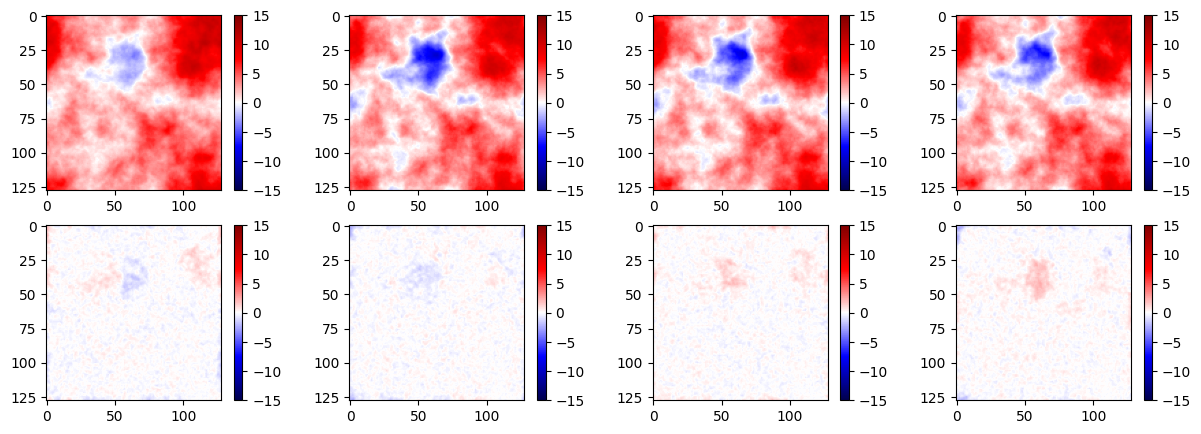

In [165]:
v = 15
plt.figure(figsize = (15, 5))
for i in range(4):
    plt.subplot(2, 4, i+1)
    if i == 0:
        plt.imshow(sample0['delta'], cmap = 'seismic', vmin = -v, vmax = v)
    else:
        plt.imshow(bounds[i], vmin = -v, vmax = v, cmap = 'seismic')
    plt.colorbar()    
res = [(x0.view(NPIX, NPIX).cpu().detach()*0 + draws[i].view(NPIX, NPIX).cpu()).numpy() for i in range(len(draws))]
for i in range(4):
    plt.subplot(2, 4, i+1+4)
    plt.imshow(res[i], vmin = -v, vmax = v, cmap = 'seismic')
    plt.colorbar()

### Round 2

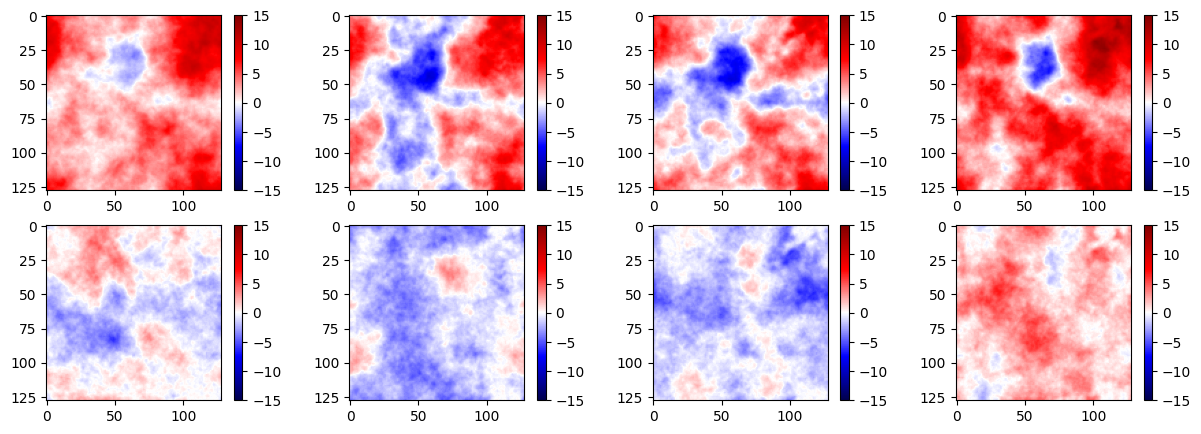

In [136]:
v = 15
plt.figure(figsize = (15, 5))
for i in range(4):
    plt.subplot(2, 4, i+1)
    if i == 0:
        plt.imshow(sample0['delta'], cmap = 'seismic', vmin = -v, vmax = v)
    else:
        plt.imshow(bounds[i], vmin = -v, vmax = v, cmap = 'seismic')
    plt.colorbar()    
res = [(x0.view(NPIX, NPIX).cpu().detach()*0 + draws[i].view(NPIX, NPIX).cpu()).numpy() for i in range(len(draws))]
for i in range(4):
    plt.subplot(2, 4, i+1+4)
    plt.imshow(res[i], vmin = -v, vmax = v, cmap = 'seismic')
    plt.colorbar()

### Round 1

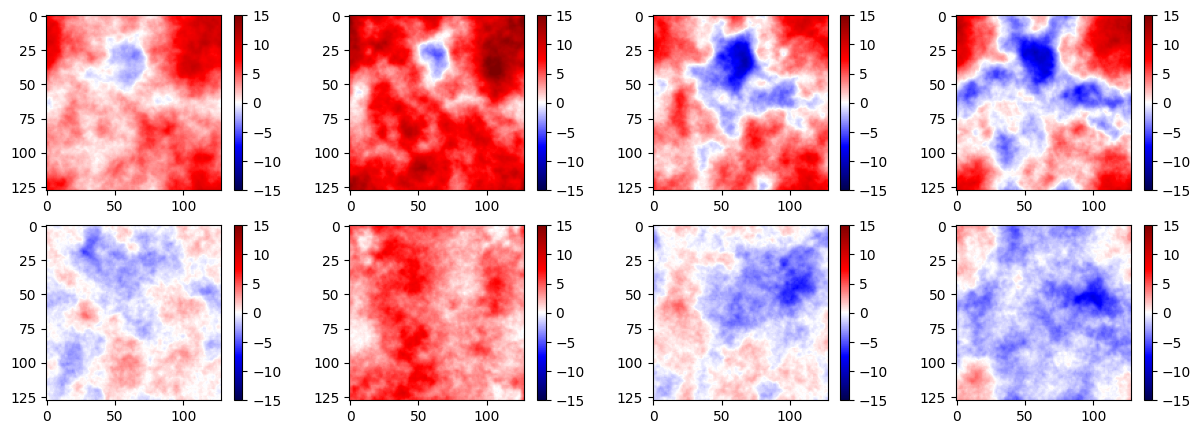

In [112]:
v = 15
plt.figure(figsize = (15, 5))
for i in range(4):
    plt.subplot(2, 4, i+1)
    if i == 0:
        plt.imshow(sample0['delta'], cmap = 'seismic', vmin = -v, vmax = v)
    else:
        plt.imshow(bounds[i], vmin = -v, vmax = v, cmap = 'seismic')
    plt.colorbar()    
res = [(x0.view(NPIX, NPIX).cpu().detach()*0 + draws[i].view(NPIX, NPIX).cpu()).numpy() for i in range(len(draws))]
for i in range(4):
    plt.subplot(2, 4, i+1+4)
    plt.imshow(res[i], vmin = -v, vmax = v, cmap = 'seismic')
    plt.colorbar()

### Round 0

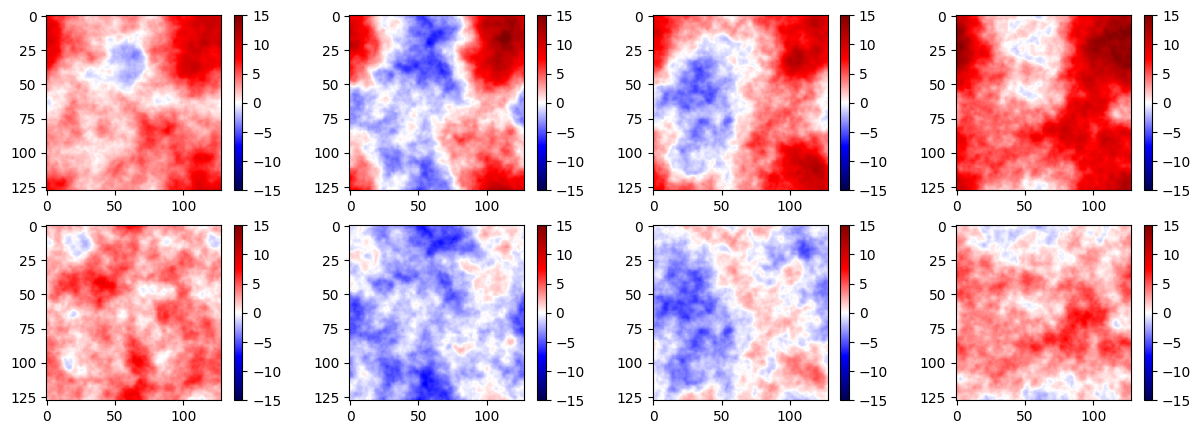

In [85]:
v = 15
plt.figure(figsize = (15, 5))
for i in range(4):
    plt.subplot(2, 4, i+1)
    if i == 0:
        plt.imshow(sample0['delta'], cmap = 'seismic', vmin = -v, vmax = v)
    else:
        plt.imshow(bounds[i], vmin = -v, vmax = v, cmap = 'seismic')
    plt.colorbar()    
res = [(x0.view(NPIX, NPIX).cpu().detach()*0 + draws[i].view(NPIX, NPIX).cpu()).numpy() for i in range(len(draws))]
for i in range(4):
    plt.subplot(2, 4, i+1+4)
    plt.imshow(res[i], vmin = -v, vmax = v, cmap = 'seismic')
    plt.colorbar()